# Classification. Linear models and KNN

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler 

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [117]:
PATH = "./data/"

In [262]:
data = pd.read_csv('train.csv').set_index('PassengerId')

In [4]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [5]:
## your code
print ('All passengers: ')
all_people=data.groupby('Sex').count().iloc[:,2]
all_people

All passengers: 


Sex
female    314
male      577
Name: Name, dtype: int64

In [6]:
print ('Survived passengers: ')
survived_people=data[data['Survived']==1].groupby('Sex').count().iloc[:,0]
survived_people

Survived passengers: 


Sex
female    233
male      109
Name: Survived, dtype: int64

In [7]:
print ('Percentage of survivors')
survived_people/all_people

Percentage of survivors


Sex
female    0.742038
male      0.188908
dtype: float64

As you can see more than 70% of women but less than 20% of men were survived. That's why there is some relationship between the gender and the survival and woman had more chance to survive than man.  

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

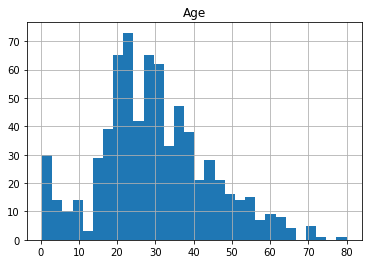

In [8]:
## your code
print ('Age distribution of all passengers')
data.hist(column='Age',bins=30)

In [9]:
print ('Average age of survived people: ')
print(data[data['Survived']==1]['Age'].mean())
print ('Median age of survived people: ')
print(data[data['Survived']==1]['Age'].median())
print ('Average age of deceased people: ')
print(data[data['Survived']==0]['Age'].mean())
print ('Median age of deceased people: ')
print(data[data['Survived']==0]['Age'].median())

Average age of survived people: 
28.343689655172415
Median age of survived people: 
28.0
Average age of deceased people: 
30.62617924528302
Median age of deceased people: 
28.0


Age distribution of survived passengers


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

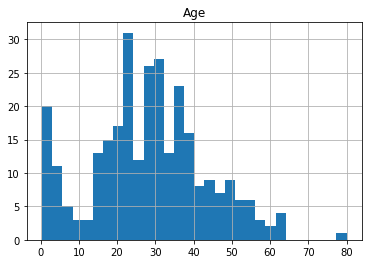

In [263]:
print ('Age distribution of survived passengers')
data[data['Survived']==1].hist(column='Age',bins=30)

Age distribution of deceased passengers


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

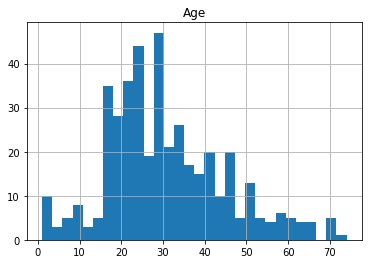

In [265]:
print ('Age distribution of deceased passengers')
data[data['Survived']==0].hist(column='Age',bins=30)

Age distributions is almost the same for survived and deceased passengers because in my opinion age of person is not really depend on survival

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Count of survived passenger depending on Pclass


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

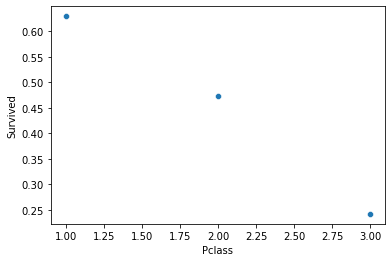

In [177]:
print ('Count of survived passenger depending on Pclass')
pcl=data.groupby('Pclass').count().iloc[:,0]
pcl_surv=data[data['Survived']==1].groupby('Pclass').count().iloc[:,0]
sns.scatterplot(data=pcl_surv/pcl)

Count of survived passenger depending on Embarked


<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

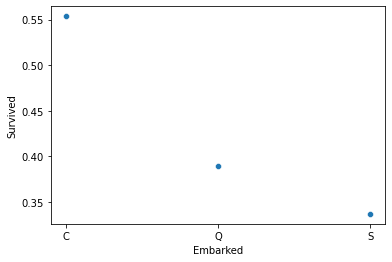

In [178]:
print ('Count of survived passenger depending on Embarked')
emb=data.groupby('Embarked').count().iloc[:,0]
emb_surv=data[data['Survived']==1].groupby('Embarked').count().iloc[:,0]
sns.scatterplot(data=emb_surv/emb)

The safest class is the first. Count of survived passenger significantly higher for those who has embarkation port C (Cherbourg)

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [139]:
## your code
miss=data.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

To handle missing values we can use several methods. 
Column 'Cabin' has more than 77% missing values, that's why I think we should drop it from dataset because information about cabin of most passengers is unknown that's why we can't rely on this statistic. But on the other hand we will lose some information which can be useful.

For column 'Age' we can apply mean inputing because it has values in type 'float'. There are only 20% of missing values in this column that's why this method won't have a big impact on dataset but some passengers with unknown age will get some fake values to this column.

For column 'Embarked' we can't use mean inputing because it has values in type 'string'. That's why the best solution will be const imputing. For example we can fill missing values with 'Unknown' and than we can use our dataset in some machine-learning algorithms. 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [51]:
y = data['Survived']
data.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

First of all let's handle missing values using methods above

In [273]:
data_dropped=data.loc[:,data.columns!='Cabin']
data_dropped['Age'].fillna(data_dropped['Age'].mean(),inplace=True)
data_dropped['Embarked'].fillna('Unknown',inplace=True)
data_dropped.isnull().mean()

D:\anaconda\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Survived    0.0
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Embarked    0.0
dtype: float64

Then let's encode non-numeric columns

In [268]:
encode=['Sex','Embarked','Pclass']
data_to_encode=data_dropped[encode]
data_to_encode

,Sex,Embarked,Pclass
PassengerId,,,
1,male,S,3
2,female,C,1
3,female,S,3
4,female,S,1
5,male,S,3
...,...,...,...
887,male,S,2
888,female,S,1
889,female,S,3


Join our encoded dataset with some columns from original dataset

In [274]:
data_prep = pd.get_dummies(data_to_encode, columns =encode)
data_prepared=data_prep.join(data_dropped[['Age','Fare','Parch','SibSp']])
data_prepared=data_prepared.loc[:,data_prepared.columns!='Embarked_Unknown']
data_prepared

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Age,Fare,Parch,SibSp
PassengerId,,,,,,,,,,,,
1,0,1,0,0,1,0,0,1,22.000000,7.2500,0,1
2,1,0,1,0,0,1,0,0,38.000000,71.2833,0,1
3,1,0,0,0,1,0,0,1,26.000000,7.9250,0,0
4,1,0,0,0,1,1,0,0,35.000000,53.1000,0,1
5,0,1,0,0,1,0,0,1,35.000000,8.0500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,1,0,0,1,0,1,0,27.000000,13.0000,0,0
888,1,0,0,0,1,1,0,0,19.000000,30.0000,0,0
889,1,0,0,0,1,0,0,1,29.699118,23.4500,2,1


Let's do the same things to test data

In [275]:
data_test = pd.read_csv('test.csv').set_index('PassengerId')
data_test.isnull().mean()

Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64

In [276]:
data_dropped=data_test.loc[:,data_test.columns!='Cabin']
data_dropped['Age'].fillna(data_dropped['Age'].mean(),inplace=True)
data_dropped['Fare'].fillna(data_dropped['Fare'].mean(),inplace=True)
encode=['Sex','Embarked','Pclass']
data_to_encode=data_dropped[encode]
data_prep = pd.get_dummies(data_to_encode, columns =encode)
data_test_prepared=data_prep.join(data_dropped[['Age','Fare','Parch','SibSp']])
data_test_prepared

D:\anaconda\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Age,Fare,Parch,SibSp
PassengerId,,,,,,,,,,,,
892,0,1,0,1,0,0,0,1,34.50000,7.8292,0,0
893,1,0,0,0,1,0,0,1,47.00000,7.0000,0,1
894,0,1,0,1,0,0,1,0,62.00000,9.6875,0,0
895,0,1,0,0,1,0,0,1,27.00000,8.6625,0,0
896,1,0,0,0,1,0,0,1,22.00000,12.2875,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,1,0,0,1,0,0,1,30.27259,8.0500,0,0
1306,1,0,1,0,0,1,0,0,39.00000,108.9000,0,0
1307,0,1,0,0,1,0,0,1,38.50000,7.2500,0,0


Then measure the accuracy using cross validation:

In [259]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector


main_model1 = LogisticRegression(solver='liblinear', penalty='l1')
main_model2=KNeighborsClassifier(n_neighbors=9)

pipe_baseline_log_reg = make_pipeline(MinMaxScaler(), main_model1)
pipe_baseline_knn = make_pipeline(MinMaxScaler(), main_model2)

print('Accuracy with Logical Regression:')
print(cross_val_score(pipe_baseline_log_reg, data_prepared, y, scoring='accuracy', cv=5).mean())

print('Accuracy with KNN:')
print(cross_val_score(pipe_baseline_knn, data_prepared, y, scoring='accuracy', cv=5).mean())

Accuracy with Logical Regression:
0.7901261691042621
Accuracy with KNN:
0.8013432929508506


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Let's use feature selection

In [179]:
selection_model = RandomForestClassifier(random_state=42)

pipe_selection_log_reg = make_pipeline(MinMaxScaler(), SelectFromModel(selection_model), main_model1) 
pipe_selection_knn = make_pipeline(MinMaxScaler(), SelectFromModel(selection_model), main_model2)

print('Accuracy with Logical Regression and feature selection:')
print(cross_val_score(pipe_selection_log_reg, data_prepared, y, scoring='accuracy', cv=5).mean())

print('Accuracy with KNN and feature selection:')
print(cross_val_score(pipe_selection_knn, data_prepared, y, scoring='accuracy', cv=5).mean())


Accuracy with Logical Regression and feature selection:
0.7833783190006904
Accuracy with KNN and feature selection:
0.7711241883116884


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

The best accuracy we achieved using KNN without feature selection

In [242]:
pipe_baseline_knn.fit(data_prepared,y)
pred=pipe_baseline_knn.predict(data_test_prepared)
output = pd.DataFrame({'PassengerId': data_test.index, 'Survived': pred})
output.to_csv('my_submission.csv', index=False)

We have score 0.77033 in kaggle

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [14]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [15]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [16]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [17]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [20]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

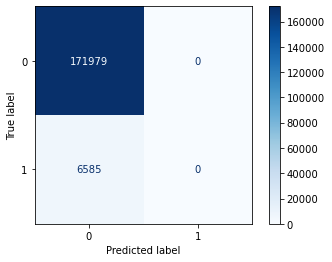

In [21]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [22]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

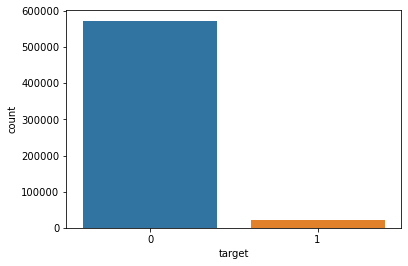

In [23]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [24]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [25]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [26]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [27]:
## your code